In [15]:
import numpy as np
import requests
from tranco import Tranco

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import requests
import json
import time
import pickle

from collections import Counter
import matplotlib.pyplot as plt

In [2]:
def get_website_size(url):
    """
    Takes a website URL as input, visits the website, and returns its size in bytes.
    
    :param url: The website URL to visit.
    :return: The size of the website content in bytes.
    """
    if("https://" not in url):
        url = f"https://www.{url}"
    
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"}
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an error for bad responses (4xx and 5xx)
        return len(response.content)
    except requests.RequestException as e:
        print(f"Error accessing {url}: {e}")
        return -1  # Return -1 in case of an error

In [3]:
url_map = {
    'https://www.amazonaws.com':'https://aws.amazon.com/',
    'https://www.akamai.net/':'https://www.akamai.com/',
    'https://www.office.net/':'https://www.office.com/',
    'https://www.whatsapp.net':'https://www.whatsapp.com/',
    'https://www.youtu.be':'https://www.youtube.com/',
    'https://www.appsflyersdk.com':'https://dev.appsflyer.com/',
    'https://www.adobe.com':'https://www.adobe.com/#',
    'https://www.windows.net':'https://www.microsoft.com/en-us/windows',
    'https://www.cloudflare.net':'https://www.cloudflare.net/home/default.aspx',
    'https://www.epicgames.com':'https://store.epicgames.com/en-US/',
    'https://www.macromedia.com':'https://www.staymacro.com/'
}

In [4]:
def count_external_resources(url: str):
    """
    Visits a website using Selenium and reports the number and size of external resources (CSS, JS, Images, Fonts).
    
    :param url: The website URL to analyze.
    :return: A dictionary with resource URLs and their sizes in bytes.
    """
    
    # add pre-amble to URLs
    if not url.startswith(("http://", "https://")):
        url = "https://" + url  # Ensure URL has proper format
    
    # re-map weird and bugged x-tranco references - often due to .net instead of .com or region-locking
    if url in url_map.keys():
        url = url_map[url]
    
    # make the browser as human-like as possible to minimze the chance of getting rejected when trying to connect
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run in headless mode
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--ignore-certificate-errors")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.set_capability("goog:loggingPrefs", {"performance": "ALL"})

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    
    driver.get(url)
    time.sleep(5)  # Allow time for network requests

    # Extract network logs
    logs = driver.get_log("performance")
    driver.quit()
    
    # also make the browser human-like
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"}

    resources = []
    for entry in logs:
        try:
            # find the resources on the page that were references inside the homepage
            log_data = json.loads(entry["message"])["message"]
            if log_data["method"] == "Network.responseReceived":
                url = log_data["params"]["response"]["url"]
                mime_type = log_data["params"]["response"]["mimeType"]
                
                # Only capture JavaScript, CSS, fonts, images, or API calls
                if any(mime in mime_type for mime in ["javascript", "css", "image", "font", "json"]):
                    try:
                        # get the size of those resources and append them into the list
                        response = requests.get(url, headers=headers, timeout=5)
                        if response.status_code == 200: # success - append data
                            resources.append({
                                'url' : url,
                                'size' : len(response.content),
                                'type' : mime_type
                            })
                    except requests.RequestException as e:
                        continue
        except Exception:
            continue  # Ignore invalid log entries

    return resources

In [5]:
t = Tranco(cache=True, cache_dir='.tranco')

latest_list = t.list()

In [6]:
x = 250

top_x = latest_list.top(x)
print(top_x)

['google.com', 'mail.ru', 'microsoft.com', 'facebook.com', 'dzen.ru', 'root-servers.net', 'amazonaws.com', 'apple.com', 'youtube.com', 'googleapis.com', 'cloudflare.com', 'akamai.net', 'twitter.com', 'instagram.com', 'a-msedge.net', 'office.com', 'akamaiedge.net', 'gstatic.com', 'azure.com', 'linkedin.com', 'speedcdns.com', 'live.com', 'googletagmanager.com', 'googlevideo.com', 'fbcdn.net', 'amazon.com', 'akadns.net', 'workers.dev', 'wikipedia.org', 'tiktokcdn.com', 'microsoftonline.com', 'doubleclick.net', 'googleusercontent.com', 'windowsupdate.com', 'l-msedge.net', 'github.com', 't-msedge.net', 'trafficmanager.net', 'bing.com', 'office.net', 'apple-dns.net', 'dual-s-msedge.net', 'fastly.net', 'wordpress.org', 'pinterest.com', 'icloud.com', 'whatsapp.net', 'youtu.be', 'aaplimg.com', 'netflix.com', 'sharepoint.com', 'appsflyersdk.com', 'domaincontrol.com', 'digicert.com', 'yahoo.com', 'skype.com', 'googlesyndication.com', 'gtld-servers.net', 'goo.gl', 'whatsapp.com', 'ax-msedge.net', 

In [9]:
website_metadata = {}

for website_url in top_x:
    try:
        size = get_website_size(website_url)
        resources = count_external_resources(website_url)
    except Exception:
        website_metadata[website_url] = {
            'size' : -1,
            'resource_data' : []
        }
    else:
        website_metadata[website_url] = {
            'size' : size,
            'resource_data' : resources
        }

Error accessing https://www.facebook.com: 400 Client Error: Bad Request for url: https://www.facebook.com/
Error accessing https://www.root-servers.net: HTTPSConnectionPool(host='www.root-servers.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd6785fb610>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error accessing https://www.amazonaws.com: HTTPSConnectionPool(host='www.amazonaws.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)')))
Error accessing https://www.googleapis.com: 404 Client Error: Not Found for url: https://www.googleapis.com/
Error accessing https://www.akamai.net: HTTPSConnectionPool(host='www.akamai.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd669f9efa0>: Failed to

Error accessing https://www.appsflyersdk.com: 403 Client Error: Forbidden for url: https://www.appsflyersdk.com/
Error accessing https://www.domaincontrol.com: HTTPSConnectionPool(host='www.domaincontrol.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd6819f9a00>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error accessing https://www.googlesyndication.com: HTTPSConnectionPool(host='www.googlesyndication.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd6819f9e80>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error accessing https://www.gtld-servers.net: HTTPSConnectionPool(host='www.gtld-servers.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0

Error accessing https://www.rbxcdn.com: HTTPSConnectionPool(host='www.rbxcdn.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd67fea2280>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error accessing https://www.health.mil: HTTPSConnectionPool(host='www.health.mil', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
Error accessing https://www.adnxs.com: HTTPSConnectionPool(host='www.adnxs.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)')))
Error accessing https://www.rocket-cdn.com: HTTPSConnectionPool(host='www.rocket-cdn.com', port=443): Max retries 

Error accessing https://www.registrar-servers.com: HTTPSConnectionPool(host='www.registrar-servers.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd6485dd220>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Error accessing https://www.azurewebsites.net: HTTPSConnectionPool(host='www.azurewebsites.net', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd6485ddee0>: Failed to establish a new connection: [Errno 61] Connection refused'))
Error accessing https://www.casalemedia.com: HTTPSConnectionPool(host='www.casalemedia.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)')))
Error accessing https://www.shifen.com: HTTPSConnectionPool(host='www.shifen.com', port=443): Max retries exceeded with url: /

Error accessing https://www.bytefcdn-ttpeu.com: HTTPSConnectionPool(host='www.bytefcdn-ttpeu.com', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fd6784c5d30>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


In [89]:
with open('website_metadata', 'wb') as f:
    pickle.dump(website_metadata, f)

In [ ]:
print(website)

In [11]:
website_to_summarize = 'tiktokv.com'

print(f"Size of {website_to_summarize}: {website_metadata[website_to_summarize]['size']} bytes")
print(f"Found {len(website_metadata['google.com']['resource_data'])} Resources in {website_to_summarize}: ")
for resource in website_metadata['google.com']['resource_data']:
    print(f"{resource['type']} resource, Size: {resource['size']} bytes.")

Size of tiktokv.com: 240727 bytes
Found 23 Resources in tiktokv.com: 
text/css resource, Size: 3795 bytes.
image/png resource, Size: 13504 bytes.
text/javascript resource, Size: 1011702 bytes.
image/webp resource, Size: 660 bytes.
text/css resource, Size: 10039 bytes.
text/javascript resource, Size: 222202 bytes.
application/json resource, Size: 11411 bytes.
text/javascript resource, Size: 120797 bytes.
text/javascript resource, Size: 9571 bytes.
text/javascript resource, Size: 414867 bytes.
text/javascript resource, Size: 117390 bytes.
image/png resource, Size: 2091 bytes.
text/javascript resource, Size: 207767 bytes.
text/css resource, Size: 957 bytes.
text/javascript resource, Size: 23988 bytes.
font/woff2 resource, Size: 10748 bytes.
font/woff2 resource, Size: 52244 bytes.
text/javascript resource, Size: 272264 bytes.
text/javascript resource, Size: 1548 bytes.
text/javascript resource, Size: 21332 bytes.
text/javascript resource, Size: 1328 bytes.
text/javascript resource, Size: 3

In [12]:
# var strogarts model for graph generation
# how are networking people modelling their networks?  What are they using
bad_count = 0
good_count = 0

for website_name, metadata in website_metadata.items():
    if metadata['size'] == -1:
        bad_count += 1
    elif metadata['size'] > 0:
        good_count += 1
        
print(f"Invalid Websites: {bad_count}")
print(f"Valid Websites: {good_count}")

Invalid Websites: 126
Valid Websites: 124


In [17]:
with open('website_metadata', 'rb') as f:
    website_metadata = pickle.load(f)
    
# Filter out websites with invalid 'size' values
filtered_metadata = {
    site: data for site, data in website_metadata.items()
    if isinstance(data.get('size'), (int, float)) and data['size'] >= 0
}

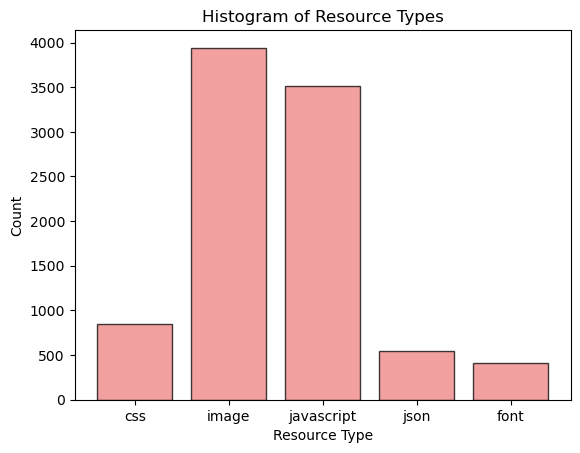

In [31]:
# Resource Type Histogram

categories = ["javascript", "css", "image", "font", "json"]
resource_counter = Counter()

# Count occurrences of each resource type
for site, data in website_metadata.items():
    for resource in data['resource_data']:
        resource_type = resource['type'].lower()
        for category in categories:
            if category in resource_type:
                resource_counter[category] += 1
                break

# Plot histogram
plt.bar(resource_counter.keys(), resource_counter.values(), color='lightcoral', edgecolor='black', alpha=0.75)
plt.xlabel("Resource Type")
plt.ylabel("Count")
plt.title("Histogram of Resource Types")
plt.show()

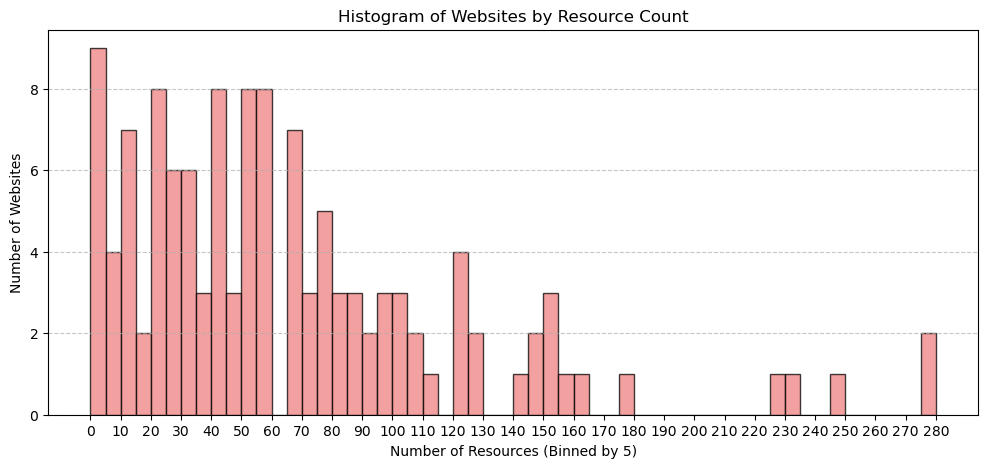

In [68]:
# Count number of resources per website
resource_counts = [len(data['resource_data']) for data in filtered_metadata.values()]

# Create bins in increments of 5
bins = np.arange(0, max(resource_counts) + 6, 5)

# Plot histogram for number of resources per website
plt.figure(figsize=(12, 5))
plt.hist(resource_counts, bins=bins, color='lightcoral', edgecolor='black', alpha=0.75)
plt.xlabel("Number of Resources (Binned by 5)")
plt.ylabel("Number of Websites")
plt.title("Histogram of Websites by Resource Count")

# Show every other x-axis tick
plt.xticks(bins[::2])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

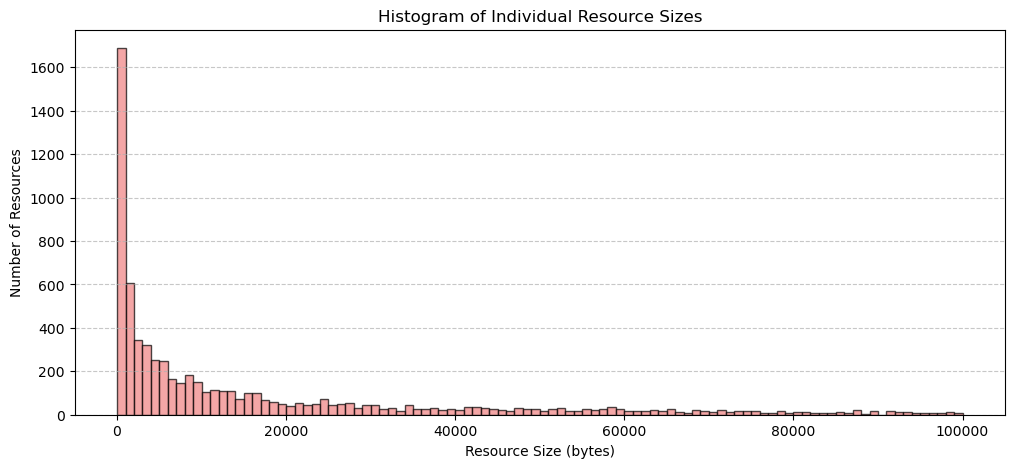

In [88]:
# Extract resource sizes and filter out those larger than 2,000,000
resource_sizes = []
for site, data in filtered_metadata.items():
    for resource in data['resource_data']:
        if resource['size'] <= 100000:
            resource_sizes.append(resource['size'])

# Define bin edges (binned by 1000)
bins = np.arange(0, max(resource_sizes) + 1000, 1000) if resource_sizes else [0, 1000]

# Plot histogram
plt.figure(figsize=(12, 5))
plt.hist(resource_sizes, bins=bins, color='lightcoral' ,edgecolor='black', alpha=0.7)
plt.xlabel("Resource Size (bytes)")
plt.ylabel("Number of Resources")
plt.title("Histogram of Individual Resource Sizes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

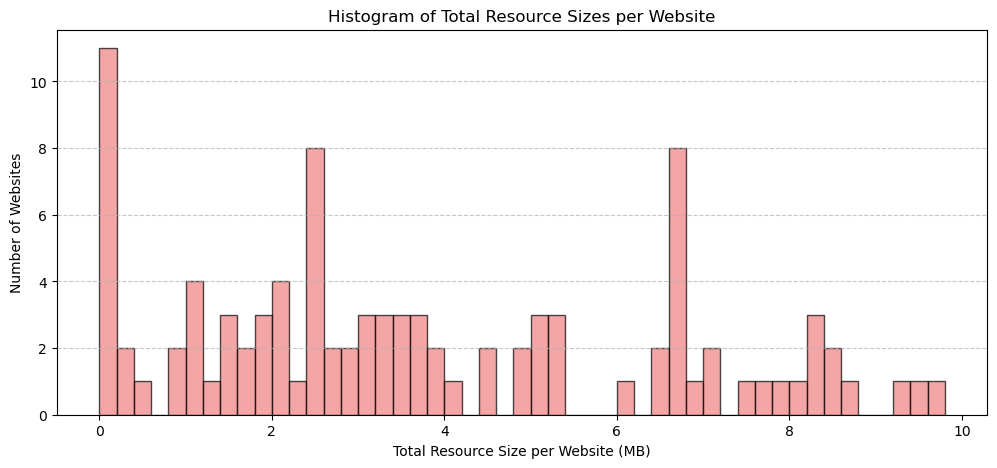

In [83]:
# Compute total resource size per website
total_resource_sizes = []
for site, data in filtered_metadata.items():
    total_size = sum(resource['size'] for resource in data['resource_data'])
    if total_size <= 10000000:
        total_resource_sizes.append(total_size)

# Convert bytes to megabytes
# Convert bytes to megabytes
total_resource_sizes_mb = [size / 1e6 for size in total_resource_sizes]

# Define bin edges (binned by 10 MB)
bins = np.arange(0, max(total_resource_sizes_mb) + .2, .2) if total_resource_sizes_mb else [0, .2]

# Plot histogram

plt.figure(figsize=(12, 5))
plt.hist(total_resource_sizes_mb, bins=bins,color='lightcoral' ,edgecolor='black', alpha=0.7)
plt.xlabel("Total Resource Size per Website (MB)")
plt.ylabel("Number of Websites")
plt.title("Histogram of Total Resource Sizes per Website")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [39]:
def count_websites_with_resources(website_metadata, target_size, deviation, count):
    """
    Computes the number of websites that contain at least `count` resources 
    within the size range `target_size +/- deviation`.
    """
    matching_websites = 0
    
    for site, data in website_metadata.items():
        matching_resources = [res for res in data['resource_data'] 
                              if target_size - deviation <= res['size'] <= target_size + deviation]
        
        if len(matching_resources) >= count:
            matching_websites += 1
    
    return matching_websites

In [42]:
target_size = 1000
deviation = 500
count = 3
matching_websites = count_websites_with_resources(website_metadata, target_size, deviation, count)
print(f"Number of websites with at least {count} resources in the size range {target_size} +/- {deviation}: {matching_websites}")

Number of websites with at least 3 resources in the size range 1000 +/- 500: 86


In [86]:
def find_all_optimal_parameters(website_metadata):
    """
    Finds the largest count for each combination of (target_size, deviation) that results in
    at least 100 matching websites, along with the corresponding number of matching websites.
    """
    optimal_combinations = {}
    
    for target_size in range(500, 10001, 100):  # Iterate over target_size in steps of 100
        for deviation in range(100, min(target_size // 2 + 1, 5001), 100):  # Deviation at most 50% of target_size
            count = 1
            max_count = 0
            max_matching_websites = 0
            while True:
                matching_websites = count_websites_with_resources(website_metadata, target_size, deviation, count)
                if matching_websites >= 100:
                    max_count = count
                    max_matching_websites = matching_websites
                if matching_websites < 100 or count > 5:
                    break  # Stop if count becomes too large
                count += 1
            
            if max_count > 0:
                optimal_combinations[(target_size, deviation)] = (max_count, max_matching_websites)
    
    return optimal_combinations

In [87]:
# Find all optimal parameters
optimal_params = find_all_optimal_parameters(website_metadata)
print("Optimal parameter combinations found:")
for (target_size, deviation), (max_count, matching_websites) in optimal_params.items():
    print(f"target_size={target_size}, deviation={deviation}, max_count={max_count}, matching_websites={matching_websites}")

Optimal parameter combinations found:
target_size=500, deviation=200, max_count=1, matching_websites=115
target_size=600, deviation=200, max_count=1, matching_websites=113
target_size=600, deviation=300, max_count=1, matching_websites=122
target_size=700, deviation=200, max_count=1, matching_websites=109
target_size=700, deviation=300, max_count=1, matching_websites=119
target_size=800, deviation=200, max_count=1, matching_websites=102
target_size=800, deviation=300, max_count=1, matching_websites=115
target_size=800, deviation=400, max_count=2, matching_websites=100
target_size=900, deviation=300, max_count=1, matching_websites=113
target_size=900, deviation=400, max_count=1, matching_websites=123
target_size=1000, deviation=300, max_count=1, matching_websites=111
target_size=1000, deviation=400, max_count=1, matching_websites=117
target_size=1000, deviation=500, max_count=2, matching_websites=101
target_size=1100, deviation=300, max_count=1, matching_websites=105
target_size=1100, de

In [8]:
# SAMPLE OUTPUT FORMATTING
website_metadata_sample = {
    "google.com" : {
        'size' : 100,
        'resource_data' : [
            {
                'url': 'https://www.google.com/foo/bar/',
                'size': 1234,
                'type': 'text/css',
            },
            {
                'url': 'https://www.google.com/lorem/ipsum/',
                'size' : 4321,
                'type' : 'text/javascript',
            },
        ]
    }
}